In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
train_dataset = ImageFolder(root='/home/idrone2/Desktop/rk/ultrasound_breast_classification/train', transform=transform)
val_dataset = ImageFolder(root='/home/idrone2/Desktop/rk/ultrasound_breast_classification/val', transform=transform)


In [5]:
# Split train dataset into train and test
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_split, test_split = random_split(train_dataset, [train_size, test_size])


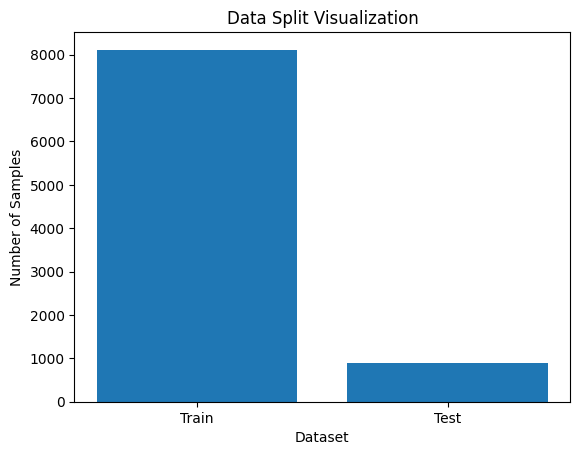

train_size 6492
test_size 1624
train_dataset Dataset ImageFolder
    Number of datapoints: 8116
    Root location: /home/idrone2/Desktop/rk/ultrasound_breast_classification/train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
test_dataset Dataset ImageFolder
    Number of datapoints: 900
    Root location: /home/idrone2/Desktop/rk/ultrasound_breast_classification/val
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [6]:
# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(val_dataset)

# Create a bar chart
plt.bar(['Train', 'Test'], [train_len, test_len])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Data Split Visualization')
plt.show()

#print('dataset', dataset)
print('train_size', train_size)
print('test_size', test_size)
print('train_dataset', train_dataset)
print('test_dataset', val_dataset)


In [7]:
# Data loaders
train_loader = DataLoader(dataset=train_split, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_split, batch_size=64, shuffle=False)


In [8]:
# Model definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, len(train_dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Model, criterion, optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 100


In [9]:
# Summary of the model
summary(model, (3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         MaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
           Dropout-8                  [-1, 256]               0
            Linear-9                    [-1, 2]             514
Total params: 618,306
Trainable params: 618,306
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 2.36
Estimated Total Size (MB): 2.92
-------------------------------------------

In [10]:
# Initialize lists for tracking metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')


Epoch [1/100], Train Loss: 0.6247, Train Accuracy: 0.6490, Val Loss: 0.5265, Val Accuracy: 0.7411
Epoch [2/100], Train Loss: 0.4855, Train Accuracy: 0.7603, Val Loss: 0.4487, Val Accuracy: 0.8111
Epoch [3/100], Train Loss: 0.4325, Train Accuracy: 0.7967, Val Loss: 0.4619, Val Accuracy: 0.7889
Epoch [4/100], Train Loss: 0.3878, Train Accuracy: 0.8192, Val Loss: 0.4194, Val Accuracy: 0.8167
Epoch [5/100], Train Loss: 0.3542, Train Accuracy: 0.8441, Val Loss: 0.3961, Val Accuracy: 0.8278
Epoch [6/100], Train Loss: 0.3337, Train Accuracy: 0.8541, Val Loss: 0.3998, Val Accuracy: 0.8044
Epoch [7/100], Train Loss: 0.3093, Train Accuracy: 0.8677, Val Loss: 0.4093, Val Accuracy: 0.7856
Epoch [8/100], Train Loss: 0.2848, Train Accuracy: 0.8808, Val Loss: 0.3651, Val Accuracy: 0.8344
Epoch [9/100], Train Loss: 0.2543, Train Accuracy: 0.8953, Val Loss: 0.3658, Val Accuracy: 0.8400
Epoch [10/100], Train Loss: 0.2388, Train Accuracy: 0.9017, Val Loss: 0.3859, Val Accuracy: 0.8100
Epoch [11/100], Tra

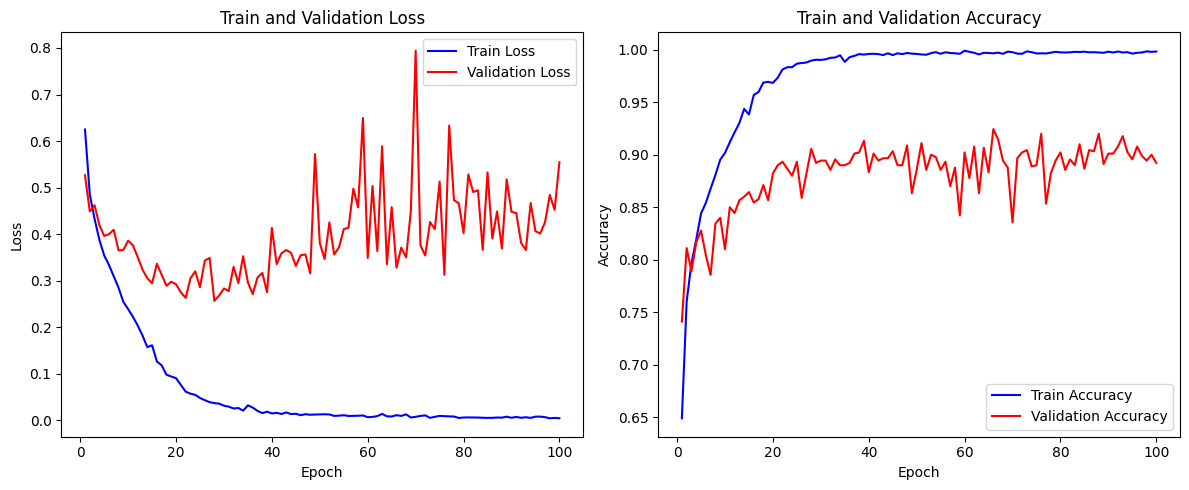

In [11]:
# Plot training and validation loss/accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

      benign       0.99      0.98      0.98       839
   malignant       0.98      0.99      0.98       785

    accuracy                           0.98      1624
   macro avg       0.98      0.98      0.98      1624
weighted avg       0.98      0.98      0.98      1624

Sensitivity (Recall) for each class:
benign: 0.9797
malignant: 0.9860


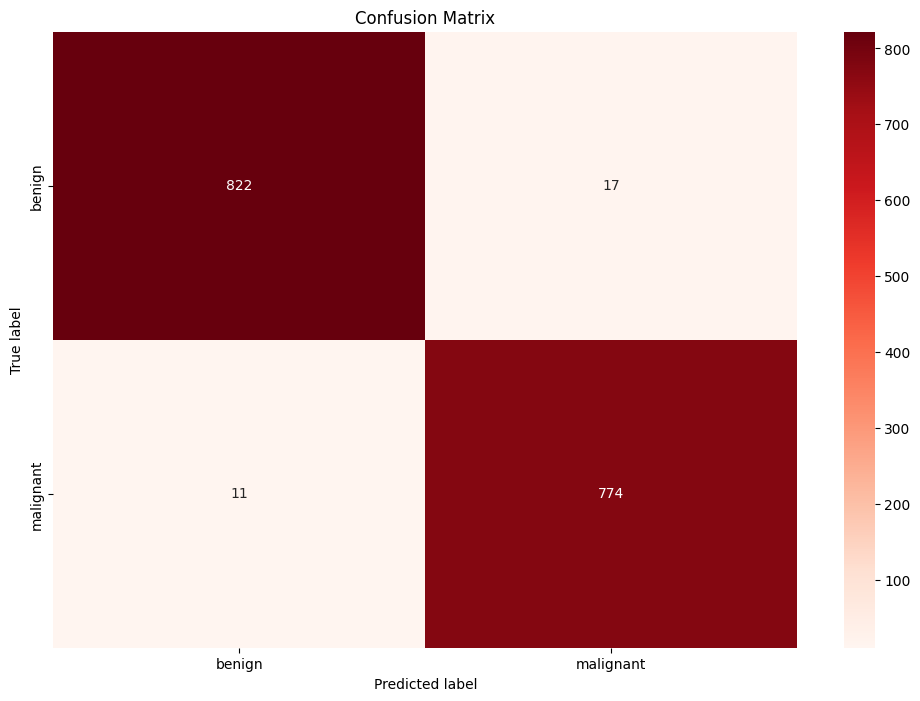

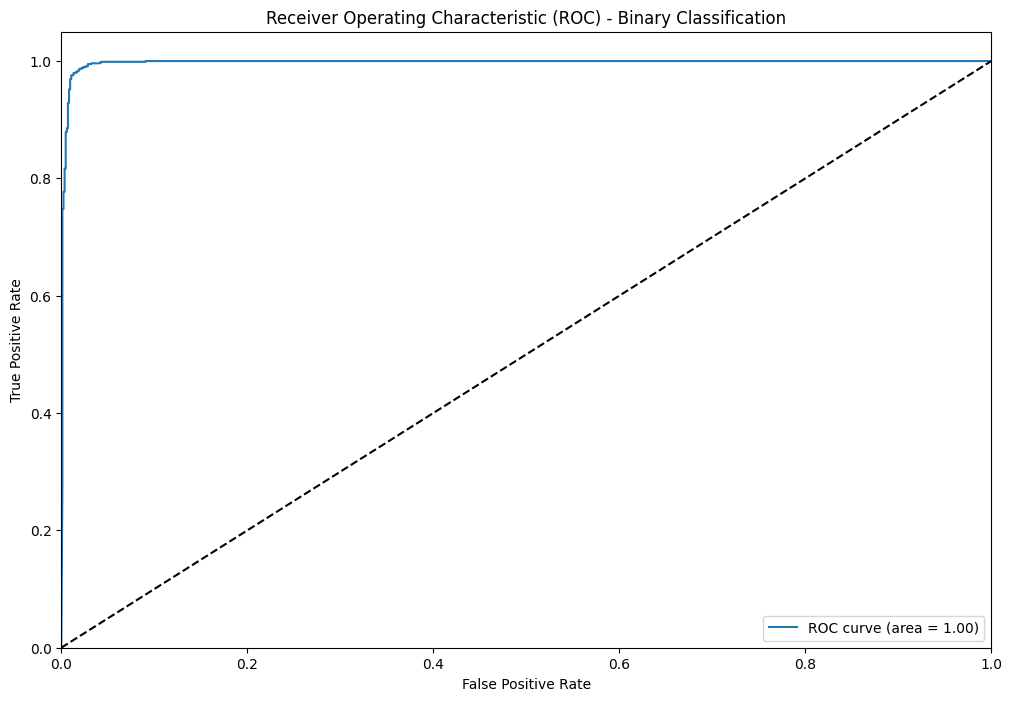

In [13]:
# Evaluate the model on the test dataset
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes, output_dict=True)
print('Classification Report:\n', classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Extract sensitivities (recall) from the report
sensitivities = {label: report[label]['recall'] for label in train_dataset.classes}
print("Sensitivity (Recall) for each class:")
for label, sensitivity in sensitivities.items():
    print(f"{label}: {sensitivity:.4f}")

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

if len(train_dataset.classes) == 2:  # Binary classification case
    # Only take the probabilities for the positive class (class 1)
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for binary classification
    plt.figure(figsize=(12, 8))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Binary Classification')
    plt.legend(loc="lower right")
    plt.show()

else:  # Multiclass classification case
    y_true_bin = label_binarize(all_labels, classes=np.arange(len(train_dataset.classes)))

    # Compute and plot ROC curve for each class
    plt.figure(figsize=(12, 8))
    for i in range(len(train_dataset.classes)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (class {train_dataset.classes[i]}) (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [1]:
import numpy as np

# Confusion matrix for first model
conf_matrix_1 = np.array([[524, 10, 8],
                          [15, 307, 8],
                          [8, 10, 281]])

# Confusion matrix for second model
conf_matrix_2 = np.array([[534, 2, 6],
                          [8, 314, 8],
                          [3, 5, 291]])

# Function to calculate accuracy, sensitivity, specificity, F1 score for a confusion matrix
def calculate_metrics(conf_matrix):
    tp = np.diag(conf_matrix)  # True Positives (diagonal)
    fp = conf_matrix.sum(axis=0) - tp  # False Positives
    fn = conf_matrix.sum(axis=1) - tp  # False Negatives
    tn = conf_matrix.sum() - (tp + fp + fn)  # True Negatives
   
    # Accuracy
    accuracy = (tp.sum()) / conf_matrix.sum()

    # Sensitivity (Recall)
    sensitivity = tp / (tp + fn)
    sensitivity_macro_avg = np.mean(sensitivity)

    # Specificity
    specificity = tn / (tn + fp)
    specificity_macro_avg = np.mean(specificity)

    # F1 Score
    precision = tp / (tp + fp)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    f1_score_macro_avg = np.mean(f1_score)
   
    return accuracy, sensitivity_macro_avg, specificity_macro_avg, f1_score_macro_avg

# Calculate metrics for both models
metrics_model_1 = calculate_metrics(conf_matrix_1)
metrics_model_2 = calculate_metrics(conf_matrix_2)

metrics_model_1, metrics_model_2

((0.9496157130657558,
  0.9456306764344627,
  0.973768061854162,
  0.9466182633374456),
 (0.9726729291204099,
  0.969999717023622,
  0.9860444844407285,
  0.9702555323252392))